In [1]:
import drag_functions_turb as fn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter
from time_TvsR import *
from PebAcc_Turb import *
from matplotlib.colors import LogNorm
import os
import time

%matplotlib inline
mpl.rcParams['font.family'] = "serif"
mpl.rcParams['text.usetex'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.direction'] = "in"
mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.direction'] = "in"
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['figure.figsize'] = (6,4)


In [2]:
def rate_odeint(m,t,p):
    alph,a_au,m_suns,temp,sig_gas,sig_p,st,verbose,verb_t = p
    cs = fn.sound_speed(temp)
    vth = fn.therm_vel(cs)
    om = fn.omega(m_suns*fn.m_sun, a_au*fn.au)
    H_g = cs/om
    rho_g = sig_gas/2./H_g
    rho_s = 2.
    vk = a_au*fn.au*om
    v0 = cs**2./2./vk
    m_earths = m/fn.m_earth
    s = st_solver(st=st,alph=alph,a_au=a_au,sig_in=sig_gas,temp_in=temp,m_earths=m_earths)
    
    rp = (3*m/4./np.pi/rho_s)**(1./3.)
    v_esc = np.sqrt(2*fn.G*m/rp)

    H_turb = np.sqrt(alph/(alph+st))*H_g
    H_KH = 2*v0/om
    H_p = max(H_turb,H_KH)
    rho_solid = sig_p/2./H_p
    v_turb = np.sqrt(alph)*cs/np.sqrt(1 + st)
    v_lam = v0*np.sqrt(1 + 4.*st**2.)/(1 + st**2.)
    v_inf = max(v_turb,v_lam)
    bGF = rp*(1 + (v_esc/v_inf)**2.)**(0.5)
    H_acc = min(H_p,bGF)
    sig_acc = 4*bGF*H_acc
    rate_GF = rho_solid*sig_acc*v_inf

    core = Core(a_core_au=a_au, m_core_earthmasses=m_earths, alpha=alph, m_star_solarmasses=m_suns, temp_in=temp,
                sig_p_in=sig_p, sig_g_in=sig_gas)
    core.main(s)
    rate_peb = m/(core.t_acc/fn.sec_to_years) # units of g/s?
    r_ws = core.r_ws
    h_r = core.r_hill
    b_r = core.r_bondi
    b_shear = core.r_sh
    #tmp,r_ws,h_r,b_r,b_shear = TvsR_sng(alph=alph,a_au=a_au,m_suns=m_suns,r=s,m_earths=m_earths,temp_in=temp,\
    #                               sig_g_in=sig_gas,sig_p_in=sig_p,out='len')
    r_tmp = min(r_ws,b_shear)
    r_stab = min(r_tmp,h_r)
    if bGF > r_stab:
        rate = rate_GF
    else:
        rate = rate_peb
#     rate = rate_peb + rate_GF
    print(rate_peb, rate_GF)
    return rate

In [6]:
a_au = 0.5
M_dot = 1e-7
m_star = 1.
L_star = 3.
st = 1e-2

#a_au = 20 #0.5
#M_dot = 1e-7
#m_star = 1.
#L_star = 1.
#st = 1e-2

sig_gas_0 = 3000.
sig_gas = sig_gas_0*(a_au)**(-1.)

T_visc = 233.*(M_dot/1e-8)**(1./4.)*m_star**(1./4.)*(a_au)**(-1.)*(sig_gas_0/3000)**(1./4.) #From flow_iso_scratch notebook
T_irr = 150.*(L_star)**(2./7.)*m_star**(-1./7.)*a_au**(-3./7.)
T = max(T_visc,T_irr)

sig_p = 5.*a_au**(-1.)

a_cgs = a_au*fn.au
m_star_cgs = m_star*fn.m_sun

c_s = np.sqrt(fn.k*T/fn.mu)
om = np.sqrt(fn.G*m_star_cgs/a_cgs**3.)
vk = a_cgs*om
v_lam = c_s**2./2./vk
H = c_s/om

alpha = (M_dot*fn.m_sun/3.154e7)/(3*np.pi*sig_gas*c_s*H)

v_turb = np.sqrt(alpha)*c_s

v_gas = np.sqrt(v_lam**2. + v_turb**2.)
aspect = H/a_cgs

rho_g = sig_gas/2./H

mfp = fn.mu/rho_g/fn.cross

In [7]:
m0_arr = np.multiply([1e-3,1e-4,1e-5],fn.m_earth)
times = np.logspace(4,6.5,num=1e5)/fn.sec_to_years

m_arr = np.zeros((len(m0_arr),len(times)))

for i,m0 in enumerate(m0_arr):
    p = [alpha,a_au,m_star,T,sig_gas,sig_p,st,1,0]
    wsol = odeint(rate_odeint,m0,times,args=(p,))
    m_arr[i] = wsol.flatten()

[8.790684e+11] [1.42585733e+12]
[8.79072211e+11] [1.42586554e+12]
[8.79072211e+11] [1.42586554e+12]
[8.79076021e+11] [1.42587375e+12]
[8.79076021e+11] [1.42587375e+12]
[8.81796622e+11] [1.4317402e+12]
[8.81796636e+11] [1.43174023e+12]
[8.84528422e+11] [1.43763683e+12]
[8.8452845e+11] [1.4376369e+12]
[8.87271493e+11] [1.44356386e+12]
[8.87271522e+11] [1.44356393e+12]
[8.98083668e+11] [1.46698502e+12]
[8.9808386e+11] [1.46698543e+12]
[8.95441536e+11] [1.46125301e+12]
[8.95441644e+11] [1.46125325e+12]
[9.03712153e+11] [1.47921441e+12]
[9.0371206e+11] [1.47921421e+12]
[9.12084274e+11] [1.49745176e+12]
[9.12084285e+11] [1.49745179e+12]
[9.20559882e+11] [1.51597108e+12]
[9.20559894e+11] [1.51597111e+12]
[9.37827623e+11] [1.5538759e+12]
[9.37827683e+11] [1.55387603e+12]
[9.55528607e+11] [1.59297233e+12]
[9.55528585e+11] [1.59297228e+12]
[9.73676282e+11] [1.6333051e+12]
[9.73676261e+11] [1.63330506e+12]
[9.92284874e+11] [1.67492156e+12]
[9.92284883e+11] [1.67492158e+12]
[1.01136916e+12] [1.717

/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide



[9.12440053e+10] [7.12510104e+10]
[9.12439945e+10] [7.12509993e+10]
[9.24012459e+10] [7.24399057e+10]
[9.24012469e+10] [7.24399067e+10]
[9.35731758e+10] [7.36488043e+10]
[9.35731768e+10] [7.36488053e+10]
[9.59618111e+10] [7.61279268e+10]
[9.59618158e+10] [7.61279317e+10]
[9.84114313e+10] [7.86911493e+10]
[9.84114293e+10] [7.86911473e+10]
[1.00923576e+11] [8.13413175e+10]
[1.00923574e+11] [8.13413155e+10]
[1.03499846e+11] [8.40813967e+10]
[1.03499847e+11] [8.40813971e+10]
[1.06141883e+11] [8.69144535e+10]
[1.06141883e+11] [8.6914454e+10]
[1.13013034e+11] [9.43888855e+10]
[1.13013041e+11] [9.43888928e+10]
[1.20328997e+11] [1.02510752e+11]
[1.20329005e+11] [1.0251076e+11]
[1.28118582e+11] [1.11336349e+11]
[1.28118573e+11] [1.11336339e+11]
[1.36412402e+11] [1.2092681e+11]
[1.36412403e+11] [1.20926811e+11]
[1.45243136e+11] [1.31348685e+11]
[1.45243139e+11] [1.31348688e+11]
[1.54645535e+11] [1.42674268e+11]
[1.54645538e+11] [1.42674272e+11]
[1.79480528e+11] [1.73657506e+11]
[1.7948059e+11] 

[1.04982773e+15] [1.93895954e+16]
[1.06286258e+15] [1.97292862e+16]
[1.06286258e+15] [1.97292862e+16]
[1.07611537e+15] [2.00764486e+16]
[1.07611537e+15] [2.00764486e+16]
[1.08959069e+15] [2.02797944e+16]
[1.08955557e+15] [2.02793343e+16]
[1.08959069e+15] [2.02797944e+16]
[1.08955291e+15] [2.02792994e+16]
[1.07879248e+15] [2.01381114e+16]
[1.078792e+15] [2.0138105e+16]
[1.07611537e+15] [2.00764486e+16]
[1.07638263e+15] [2.00834681e+16]
[1.07638273e+15] [2.00834706e+16]
[1.07611537e+15] [2.00764486e+16]
[1.0761421e+15] [2.00771505e+16]
[1.0761421e+15] [2.00771505e+16]
[1.07616883e+15] [2.00778525e+16]
[1.07616883e+15] [2.00778525e+16]
[1.07619555e+15] [2.00785545e+16]
[1.07619556e+15] [2.00785545e+16]
[1.07622228e+15] [2.00792565e+16]
[1.07622229e+15] [2.00792566e+16]
[1.07624902e+15] [2.00799586e+16]
[1.07624902e+15] [2.00799586e+16]
[1.07630248e+15] [2.00813629e+16]
[1.07630248e+15] [2.00813629e+16]
[1.07635595e+15] [2.00827672e+16]
[1.07635595e+15] [2.00827672e+16]
[1.07640942e+15] [2

[7.83300097e+12] [2.62002202e+13]
[8.63109782e+12] [2.98156807e+13]
[8.63109981e+12] [2.98156898e+13]
[9.54131121e+12] [3.40767492e+13]
[9.54131407e+12] [3.40767628e+13]
[1.05840357e+13] [3.91268264e+13]
[1.05840395e+13] [3.91268454e+13]
[1.03973365e+13] [3.82098997e+13]
[1.03973386e+13] [3.82099096e+13]
[1.13588242e+13] [4.29890256e+13]
[1.13588246e+13] [4.29890276e+13]
[1.2442521e+13] [4.85391231e+13]
[1.24425235e+13] [4.85391364e+13]
[1.36684822e+13] [5.50144077e+13]
[1.36684845e+13] [5.50144199e+13]
[1.50608322e+13] [6.26062413e+13]
[1.50608357e+13] [6.26062606e+13]
[1.66487826e+13] [7.15538347e+13]
[1.66487876e+13] [7.15538633e+13]
[1.84679196e+13] [8.2158371e+13]
[1.84679264e+13] [8.21584111e+13]
[1.81421337e+13] [8.02325155e+13]
[1.81421372e+13] [8.02325363e+13]
[1.98194652e+13] [9.02676565e+13]
[1.98194659e+13] [9.02676607e+13]
[2.17099937e+13] [1.01921748e+14]
[2.17099982e+13] [1.01921776e+14]
[2.38487077e+13] [1.15518646e+14]
[2.38487117e+13] [1.15518672e+14]
[2.62776953e+13]

No handles with labels found to put in legend.


(1e-06, 200.0)

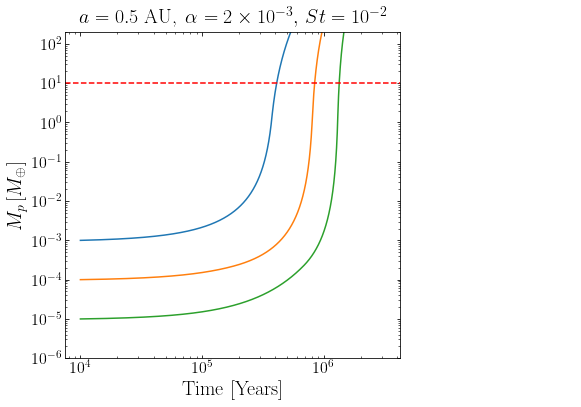

In [9]:
fig = plt.figure(figsize=(6,6))

# labels = [r'$M_0 = 10^{-7} M_\oplus$',r'$M_0 = 10^{-6} M_\oplus$',r'$M_0 = 10^{-5} M_\oplus$']

for i in range(len(m0_arr)):
    plt.loglog(times*fn.sec_to_years,m_arr[i]/fn.m_earth)
    
# plt.ylim([1e-8,1e2])
plt.xlabel('Time [Years]',fontsize=20)
plt.ylabel(r'$M_p \, [M_\oplus]$',fontsize=20)

plt.axhline(y=1e1,linestyle='dashed',color='r')

lgd = plt.gca().legend(bbox_to_anchor=[1.55,0.70],frameon=False)

plt.title(r'$a = 0.5$ AU,\, $\alpha = 2 \times 10^{-3}, \, St = 10^{-2}$',y=1.01)
plt.ylim(1e-6,2e2)
# plt.tight_layout()

In [17]:
fig.savefig('M_vs_t.pdf',bbox_inches='tight')

## Trying to reproduce plot from poster

In [39]:
a_au = 20 #0.5
M_dot = 1e-7
m_star = 1.
L_star = 3. #1.
st = 1e-2

sig_gas_0 = 3000.
sig_gas = sig_gas_0*(a_au)**(-1.)

T_visc = 233.*(M_dot/1e-8)**(1./4.)*m_star**(1./4.)*(a_au)**(-1.)*(sig_gas_0/3000)**(1./4.) #From flow_iso_scratch notebook
T_irr = 150.*(L_star)**(2./7.)*m_star**(-1./7.)*a_au**(-3./7.)
T = max(T_visc,T_irr)

sig_p = 5.*a_au**(-1.)

a_cgs = a_au*fn.au
m_star_cgs = m_star*fn.m_sun

c_s = np.sqrt(fn.k*T/fn.mu)
om = np.sqrt(fn.G*m_star_cgs/a_cgs**3.)
vk = a_cgs*om
v_lam = c_s**2./2./vk
H = c_s/om

alpha = 1e-5 #(M_dot*fn.m_sun/3.154e7)/(3*np.pi*sig_gas*c_s*H) # 1e-5

v_turb = np.sqrt(alpha)*c_s

v_gas = np.sqrt(v_lam**2. + v_turb**2.)
aspect = H/a_cgs

rho_g = sig_gas/2./H

mfp = fn.mu/rho_g/fn.cross

In [40]:
m0_arr = np.multiply([1e-5,1e-6,1e-7],fn.m_earth)
times = np.logspace(3,7,num=1e5)/fn.sec_to_years

m_arr = np.zeros((len(m0_arr),len(times)))

for i,m0 in enumerate(m0_arr):
    p = [alpha,a_au,m_star,T,sig_gas,sig_p,st,1,0]
    wsol = odeint(rate_odeint,m0,times,args=(p,))
    m_arr[i] = wsol.flatten()

[6.64611864e+09] [38172995.93569243]
[6.64612079e+09] [38173012.3443253]
[6.64612079e+09] [38173012.3443306]
[6.64612294e+09] [38173028.75297053]
[6.64612294e+09] [38173028.75297586]
[6.66764193e+09] [38337468.57396246]
[6.66764199e+09] [38337469.00308645]
[6.6892306e+09] [38502617.72066607]
[6.68923071e+09] [38502618.58122716]
[6.71088923e+09] [38668479.68564533]
[6.71088934e+09] [38668480.54991967]
[6.82917487e+09] [39577435.38913378]
[6.82917631e+09] [39577446.4315631]
[6.80063271e+09] [39357624.15118482]
[6.80063353e+09] [39357630.43128279]
[6.89157874e+09] [40059085.79816613]
[6.89157804e+09] [40059080.33472992]
[6.98373864e+09] [40773047.80423268]
[6.98373873e+09] [40773048.48229757]
[7.07713179e+09] [41499757.86257463]
[7.07713188e+09] [41499758.56147184]
[7.26768126e+09] [42992315.0739524]
[7.2676817e+09] [42992318.52028542]
[7.46336219e+09] [44538631.28124784]
[7.46336201e+09] [44538629.83830436]
[7.66431115e+09] [46140631.20761739]
[7.66431097e+09] [46140629.7813619]
[7.87067

[1.09553652e+15] [3.43173818e+14]
[1.24764601e+15] [4.08131498e+14]
[1.2476461e+15] [4.08131539e+14]
[1.42087537e+15] [4.85384822e+14]
[1.42087533e+15] [4.85384804e+14]
[1.61815656e+15] [5.77260988e+14]
[1.61815653e+15] [5.77260975e+14]
[1.84282919e+15] [6.86527942e+14]
[1.84282922e+15] [6.86527953e+14]
[2.07266628e+15] [8.16477551e+14]
[2.07196303e+15] [8.15923589e+14]
[2.07194403e+15] [8.15908623e+14]
[2.04988849e+15] [7.98630631e+14]
[2.04953404e+15] [7.98354475e+14]
[2.04952526e+15] [7.98347633e+14]
[1.88511677e+15] [7.07612952e+14]
[1.88511677e+15] [7.07612952e+14]
[1.9283747e+15] [7.29345524e+14]
[1.9283747e+15] [7.29345524e+14]
[1.97262527e+15] [7.51745558e+14]
[1.97262527e+15] [7.51745558e+14]
[2.01789126e+15] [7.74833554e+14]
[2.01789126e+15] [7.74833554e+14]
[2.0498885e+15] [7.9863064e+14]
[2.04981358e+15] [7.98572266e+14]
[2.0498885e+15] [7.9863064e+14]
[2.04980791e+15] [7.98567847e+14]
[2.02523403e+15] [7.79535557e+14]
[2.02523172e+15] [7.79533778e+14]
[2.01789126e+15] [7.7

/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide


In [41]:
print(m0_arr/fn.m_earth)

[1.e-05 1.e-06 1.e-07]


No handles with labels found to put in legend.


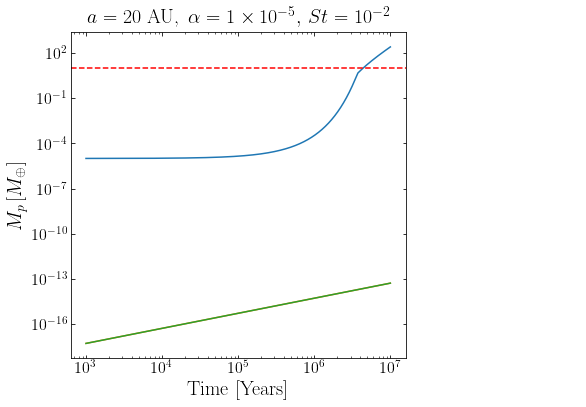

In [42]:
fig = plt.figure(figsize=(6,6))

# labels = [r'$M_0 = 10^{-7} M_\oplus$',r'$M_0 = 10^{-6} M_\oplus$',r'$M_0 = 10^{-5} M_\oplus$']

for i in range(len(m0_arr)):
    plt.loglog(times*fn.sec_to_years,m_arr[i]/fn.m_earth)
    
plt.xlabel('Time [Years]',fontsize=20)
plt.ylabel(r'$M_p \, [M_\oplus]$',fontsize=20)

plt.axhline(y=1e1,linestyle='dashed',color='r')

lgd = plt.gca().legend(bbox_to_anchor=[1.55,0.70],frameon=False)

plt.title(r'$a = 20$ AU,\, $\alpha = 1 \times 10^{-5}, \, St = 10^{-2}$',y=1.01);
#plt.ylim(1e-6,2e2)